 # Python Practice for KMP (reproduction)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from utils import (load_letter_all, split_indices, preprocess_demo, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

#################################################<br>
Load the training data<br>
#################################################

In [26]:
mat = loadmat('../2Dletters/refG.mat') # Reference trajectory is extracted from five demonstrations
dim = 2  # 2D trajectory
Dim = 2 * dim # both position and velocity
len = mat['refTraj'].shape[1] # length of the reference trajectory

In [27]:
ref_t = np.zeros(len) # input of the reference trajectory
ref_mu = np.zeros((Dim, len)) # mean of the reference trajectory
ref_cov = np.zeros((Dim, Dim*len)) # covariance of the reference trajectory
for i in range(len):
    ref_t[i] = mat['refTraj'][0, i]['t']
    ref_mu[:, i] = mat['refTraj'][0, i]['mu'][:, 0]
    ref_cov[:, i*Dim:(i+1)*Dim] = mat['refTraj'][0, i]['sigma']
print(ref_t.shape)
print(ref_mu.shape)
print(ref_cov.shape)

(200,)
(4, 200)
(4, 800)


#################################################<br>
Define variables and set parameters for KMP<br>
#################################################

In [28]:
dt = 0.005 # time interval
tau = dt * len # motion duration
lb = 0.1 # regularization parameter
kh = 20 # kernel parameter

#################################################<br>
Kernel function<br>
#################################################

In [29]:
def kernel(x1, x2, kh):
    return np.exp(-kh * np.dot(x1-x2, x1-x2))

In [30]:
def kernel_extend(ta, tb, kh, dim):
    kt_t = kernel(ta, tb, kh)
    kt_dt = (kernel(ta, tb+dt, kh) - kernel(ta, tb, kh)) / dt
    kdt_t = (kernel(ta+dt, tb, kh) - kernel(ta, tb, kh)) / dt
    kdt_dt = (kernel(ta+dt, tb+dt, kh) - kernel(ta, tb+dt, kh) - kernel(ta+dt, tb, kh) + kernel(ta, tb, kh)) / dt**2
    kernelMatrix=np.zeros((Dim, Dim))
    for i in range(dim):
        kernelMatrix[i, i] = kt_t
        kernelMatrix[i, i+dim] = kt_dt
        kernelMatrix[i+dim, i] = kdt_t
        kernelMatrix[i+dim, i+dim] = kdt_dt
    return kernelMatrix

#################################################<br>
Prediction using KMP<br>
#################################################

In [31]:
Kc = np.zeros((len*Dim, len*Dim))
for i in range(len):
    for j in range(len):
        Kc[i*Dim:(i+1)*Dim, j*Dim:(j+1)*Dim] = kernel_extend(ref_t[i], ref_t[j], kh, dim)
        if i == j:
            Kc[i*Dim:(i+1)*Dim, j*Dim:(j+1)*Dim] += lb * ref_cov[:, i*Dim:(i+1)*Dim]

In [32]:
Kinv = np.linalg.pinv(Kc)
Mu = ref_mu.flatten(order='F')
KinvMu = np.matmul(Kinv, Mu) # (Kc+lb*Sigma)^{-1}*Mu

In [33]:
ks = np.zeros((Dim, Dim*len))
pred_pv = np.zeros((Dim, len))
for i in range(len):
    t = (i+1) * dt
    for j in range(len):
        ks[:, j*Dim:(j+1)*Dim] = kernel_extend(t, ref_t[j], kh, dim)
    pred_pv[:, i] = np.matmul(ks, KinvMu) # ks*(Kc+lb*Sigma)^{-1}*Mu

#################################################<br>
Plot predicted trajectories<br>
#################################################-

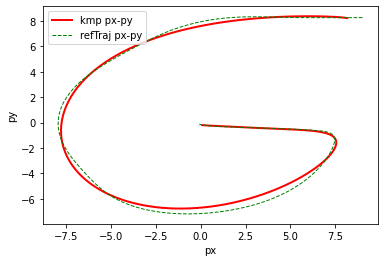

In [34]:
plt.plot(pred_pv[0], pred_pv[1], 'r', label='kmp px-py', linewidth=2)
plt.plot(ref_mu[0, :], ref_mu[1, :], 'g--', linewidth=1, label='refTraj px-py')
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

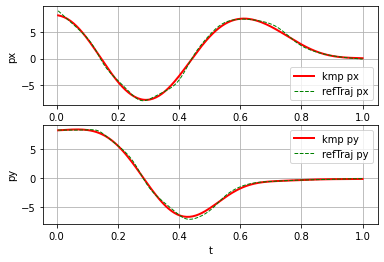

In [35]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(ref_t, pred_pv[0], 'r', label='kmp px', linewidth=2)
ax1.plot(ref_t, ref_mu[0, :], 'g--', linewidth=1, label='refTraj px')
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(ref_t, pred_pv[1], 'r', label='kmp py', linewidth=2)
ax2.plot(ref_t, ref_mu[1, :], 'g--', linewidth=1, label='refTraj py')
ax2.set_ylabel("py")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

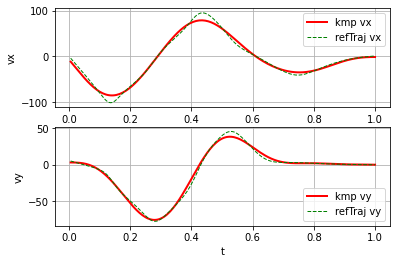

In [36]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(ref_t, pred_pv[2], 'r', label='kmp vx', linewidth=2)
ax1.plot(ref_t, ref_mu[2, :], 'g--', linewidth=1, label='refTraj vx')
ax1.set_ylabel("vx")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(ref_t, pred_pv[3], 'r', label='kmp vy', linewidth=2)
ax2.plot(ref_t, ref_mu[3, :], 'g--', linewidth=1, label='refTraj vy')
ax2.set_ylabel("vy")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

In [6]:
# ===== ProMP LOO reproduction (paste & run) =====
import numpy as np
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

def rbf_design_matrix(T, num_basis=20, width=50.0):
    t = np.linspace(0,1,T)
    c = np.linspace(0,1,num_basis)
    Phi = np.exp(-width*(t[:,None]-c[None,:])**2)   # (T,B)
    Phi = Phi / (Phi.sum(axis=1, keepdims=True)+1e-8)
    return Phi

def promp_fit_W(preps_train, num_basis=20, width=50.0, lam=1e-6):
    """用训练集学习每条演示的权重，再求 mu_w, Sigma_w"""
    T = preps_train[0]['pos'].shape[1]
    Phi = rbf_design_matrix(T, num_basis, width)            # (T,B)
    # 只用位置做 ProMP（2 维），把设计矩阵扩成 block 对角
    Phi2 = np.kron(np.eye(2), Phi)                          # (2T, 2B)
    W = []
    for p in preps_train:
        y = p['pos'].reshape(-1,1)                          # vec(2,T)->(2T,1)
        w = np.linalg.solve(Phi2.T@Phi2 + lam*np.eye(Phi2.shape[1]), Phi2.T@y).reshape(-1)
        W.append(w)
    W = np.stack(W, axis=0)                                 # (H, 2B)
    mu_w = W.mean(axis=0)
    Sigma_w = np.cov(W.T) + lam*np.eye(W.shape[1])
    return mu_w, Sigma_w, Phi2

def promp_predict(mu_w, Phi2):
    y = Phi2 @ mu_w     # (2T,)
    return y.reshape(2, -1)

# 统一配置
letters   = ['A','B','G','H']
T         = 200
num_basis = 25
width     = 60.0
save_csv  = 'results/reproduction_LOO.csv'
csv_header= ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']

for letter in letters:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[ProMP:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        # 训练：得到 mu_w, Sigma_w
        with timer() as t_train:
            mu_w, Sigma_w, Phi2 = promp_fit_W(preps_tr, num_basis=num_basis, width=width, lam=1e-6)
        train_ms = t_train()

        # 预测：用 mu_w 生成均值轨迹
        with timer() as t_infer:
            y_pred_n = promp_predict(mu_w, Phi2)            # (2,T)
        infer_ms = t_infer()

        # 评估（反归一化）
        y_pred = denormalize(y_pred_n, prep_te['stats'])
        y_true = denormalize(prep_te['pos'], prep_te['stats'])
        m = rmse(y_true, y_pred)
        e = endpoint_err(y_true, y_pred)
        j = jerk_score(y_pred, prep_te['dt'])

        append_csv(save_csv, csv_header, ['ProMP', letter, fold, m, e, j, train_ms, infer_ms])
        print(f'  fold={fold:02d}  RMSE={m:.4f}  end={e:.4f}  jerk={j:.4f}')
print('ProMP reproduction LOO done ->', save_csv)


[ProMP:A] demos=10
  fold=00  RMSE=3.2162  end=1.2102  jerk=27520.7457
  fold=01  RMSE=0.6448  end=0.6063  jerk=21011.2684
  fold=02  RMSE=0.5299  end=0.7838  jerk=21512.7037
  fold=03  RMSE=0.4045  end=0.1122  jerk=21300.3333
  fold=04  RMSE=0.6319  end=0.3979  jerk=20756.3782
  fold=05  RMSE=0.4830  end=0.0656  jerk=18964.5308
  fold=06  RMSE=0.5462  end=0.1963  jerk=20959.8419
  fold=07  RMSE=1.5569  end=0.1918  jerk=21562.1909
  fold=08  RMSE=0.5049  end=1.0786  jerk=21300.2577
  fold=09  RMSE=0.5416  end=0.9205  jerk=21696.0120
[ProMP:B] demos=12
  fold=00  RMSE=1.4299  end=1.1201  jerk=27018.3441
  fold=01  RMSE=1.4813  end=0.3452  jerk=28203.2702
  fold=02  RMSE=0.8489  end=0.4239  jerk=28428.3200
  fold=03  RMSE=0.5407  end=0.0734  jerk=28016.8605
  fold=04  RMSE=0.8935  end=0.4787  jerk=27369.0127
  fold=05  RMSE=1.7554  end=0.3151  jerk=28805.0694
  fold=06  RMSE=1.8909  end=0.9661  jerk=29904.3423
  fold=07  RMSE=2.0999  end=0.5162  jerk=28751.8224
  fold=08  RMSE=0.8147  en

In [9]:
# ===== KMP / U-KMP : LOO reproduction (paste & run) =====
import numpy as np
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

# --- 时间核（RBF） ---
def rbf_kernel(t1, t2, length=0.06):
    t1 = np.asarray(t1).reshape(-1,1)
    t2 = np.asarray(t2).reshape(-1,1)
    d2 = (t1 - t2.T)**2
    return np.exp(-0.5 * d2 / (length**2))

def build_ref_from_train(preps_train):
    """把训练集平均为参考分布 μ(t)、并给出逐时刻方差 Σ(t)（2 维分别统计）"""
    T = preps_train[0]['pos'].shape[1]
    D = preps_train[0]['pos'].shape[0]
    stack = np.stack([p['pos'] for p in preps_train], axis=0)   # (H, D, T)
    mu = stack.mean(axis=0)                                     # (D,T)
    var = stack.var(axis=0) + 1e-8                              # (D,T) 逐时刻方差
    return mu, var

def kmp_predict(mu_d, var_d, t_ref, t_query, length=0.06, lam=1e-4, use_u=False):
    """
    单维 KMP 预测：
      - mu_d: (T,) 参考均值
      - var_d: (T,) 参考方差（仅 U-KMP 使用）
      - use_u=False：普通 KMP，正则是 lam*I
      - use_u=True ：U-KMP，正则是 lam*diag(var_d)
    """
    K = rbf_kernel(t_ref, t_ref, length)                         # (T,T)
    if use_u:
        R = lam * np.diag(var_d)                                 # 不确定性感知
    else:
        R = lam * np.eye(len(t_ref))
    alpha = np.linalg.solve(K + R, mu_d)                         # (T,)
    K_s = rbf_kernel(t_query, t_ref, length)                     # (Tq, T)
    mu_q = K_s @ alpha                                           # (Tq,)
    return mu_q

# ---- 驱动：LOO 复现 ----
letters   = ['A','B','G','H']
T         = 200
length    = 0.06
lam       = 1e-4

# 两个 CSV：普通 KMP 和 U-KMP 分开存
csv_header = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']
csv_kmp    = 'results/reproduction_LOO_kmp.csv'
csv_ukmp   = 'results/reproduction_LOO_ukmp.csv'

for letter in letters:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[KMP:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        # 参考分布 μ(t), Σ(t)
        with timer() as t_train:
            mu, var = build_ref_from_train(preps_tr)            # (2,T)
            t_ref = np.linspace(0,1,mu.shape[1])
        train_ms = t_train()

        t_q = np.linspace(0,1,prep_te['pos'].shape[1])

        # --- 普通 KMP ---
        with timer() as t_infer:
            y_pred_n = np.vstack([
                kmp_predict(mu[0], var[0], t_ref, t_q, length, lam, use_u=False),
                kmp_predict(mu[1], var[1], t_ref, t_q, length, lam, use_u=False)
            ])
        infer_ms = t_infer()

        y_pred = denormalize(y_pred_n, prep_te['stats'])
        y_true = denormalize(prep_te['pos'], prep_te['stats'])
        m = rmse(y_true, y_pred)
        e = endpoint_err(y_true, y_pred)
        j = jerk_score(y_pred, prep_te['dt'])
        append_csv(csv_kmp, csv_header, ['KMP', letter, fold, m, e, j, train_ms, infer_ms])

        # --- U-KMP（不确定性感知） ---
        with timer() as t_infer2:
            y_pred_n2 = np.vstack([
                kmp_predict(mu[0], var[0], t_ref, t_q, length, lam, use_u=True),
                kmp_predict(mu[1], var[1], t_ref, t_q, length, lam, use_u=True)
            ])
        infer_ms2 = t_infer2()
        y_pred2 = denormalize(y_pred_n2, prep_te['stats'])
        m2 = rmse(y_true, y_pred2); e2 = endpoint_err(y_true, y_pred2); j2 = jerk_score(y_pred2, prep_te['dt'])
        append_csv(csv_ukmp, csv_header, ['U-KMP', letter, fold, m2, e2, j2, train_ms, infer_ms2])

        print(f'  fold={fold:02d}  KMP  RMSE={m:.4f} end={e:.4f} jerk={j:.4f} | '
              f'U-KMP RMSE={m2:.4f} end={e2:.4f} jerk={j2:.4f}')
print('KMP/U-KMP reproduction LOO done ->', csv_kmp, ' & ', csv_ukmp)


[KMP:A] demos=10
  fold=00  KMP  RMSE=3.2197 end=0.9875 jerk=30368.6980 | U-KMP RMSE=3.2197 end=0.9920 jerk=30425.2620
  fold=01  KMP  RMSE=0.6412 end=0.7877 jerk=25013.3211 | U-KMP RMSE=0.6410 end=0.7822 jerk=24843.6552
  fold=02  KMP  RMSE=0.5203 end=0.6805 jerk=25733.2005 | U-KMP RMSE=0.5203 end=0.6841 jerk=25515.8777
  fold=03  KMP  RMSE=0.3953 end=0.0771 jerk=25353.2504 | U-KMP RMSE=0.3950 end=0.0731 jerk=25195.4625
  fold=04  KMP  RMSE=0.6313 end=0.3927 jerk=25229.3543 | U-KMP RMSE=0.6312 end=0.3930 jerk=25005.0578
  fold=05  KMP  RMSE=0.4721 end=0.1328 jerk=22347.7153 | U-KMP RMSE=0.4721 end=0.1297 jerk=22254.3654
  fold=06  KMP  RMSE=0.5382 end=0.2211 jerk=24444.7773 | U-KMP RMSE=0.5384 end=0.2172 jerk=24373.9736
  fold=07  KMP  RMSE=1.5621 end=0.0753 jerk=25528.0377 | U-KMP RMSE=1.5622 end=0.0732 jerk=25215.1909
  fold=08  KMP  RMSE=0.5075 end=0.9160 jerk=25277.7504 | U-KMP RMSE=0.5074 end=0.9224 jerk=25092.7589
  fold=09  KMP  RMSE=0.5354 end=1.1042 jerk=25695.5071 | U-KMP RM